<a href="https://colab.research.google.com/github/ar851060/palm_detection_prediction/blob/main/CCBDA_final_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"


rcParams['figure.figsize'] = 10,10

meaning = pickle.load(open("/content/drive/Shareddrives/CCBDA_final/meaningDict.pkl", 'rb'))
features = pd.read_csv("/content/drive/Shareddrives/CCBDA_final/生命線.csv").columns[2:-1]
temp = []
for x in features:
  if x == "末端包覆金星丘":
    x = "末段包覆金星丘"
  if x == "整體雜亂無章":
    x = "後段雜亂無章"
  if x == "發端呈尖三角":
    x = x + "形"
  if x == "末端深入掌根":
    x = "末段深入掌根"
  temp.append(x)
features = temp

## UNet

In [ ]:
import torch.nn as nn
from torchvision import transforms, datasets, models

trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # imagenet
])

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(out_channels)
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)


  def forward(self, input):
    input = input.float()

    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

## Autoencoder

In [ ]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),        
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),   # medium: remove this layer
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # medium: remove this layer
            nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        en_x = self.encoder(x)
        de_x = self.decoder(en_x)
        return en_x, de_x

## SimCLR

In [ ]:
from torchvision.models import resnet18
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_dim = 256
        self.out_dim = 1000
        self.encoder = resnet18(pretrained = True, num_classes = self.out_dim)
        self.num_features = self.encoder.fc.out_features
        self.encoder.fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(512,128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace = True),
            nn.Linear(128,32, bias=False),
            nn.BatchNorm1d(32),
        )
    def forward(self,x):
        h = self.encoder(x)
        z = self.fc(h)
        return h, z

# Demo Start

In [ ]:
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pickle
from PIL import Image

uploaded = files.upload()

# im = Image.open('/content/PXL_20220624_041000159.jpg')
# im.save('/content/PXL_20220624_041000159.png')
images = {name: cv2.resize(cv2.imread(name), (256, 256), interpolation=cv2.INTER_AREA) for name in uploaded.keys()}

Saving 294479438_947536263307933_5439517466977078659_n.jpg to 294479438_947536263307933_5439517466977078659_n.jpg


# Process

## Autoencoder

In [ ]:
checkpoint_path = '/content/drive/Shareddrives/CCBDA_final/best_model_cnn.pt'
model = torch.load(checkpoint_path)
model.eval()

for name, img in images.items():
  img = torch.tensor(img).to(torch.float32)
  img = torch.unsqueeze(img, 0).permute((0,3,1,2))
  img = img.to(device)
  embbeding, _ = model(img)
  embbeding = embbeding[0].flatten().detach().cpu().numpy()

## UNet

In [ ]:
import cv2
checkpoint_path = "/content/drive/Shareddrives/CCBDA_final/checkpoint.pth"
model = ResNetUNet(1).to(device)
model.load_state_dict(torch.load(checkpoint_path))

model.eval() 
for name, img in images.items():
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype('float32') / 255.0
  img = trans(img)
  img = torch.unsqueeze(img, 0)
  img = img.to(device)
  line = model(img)
  line = torch.sigmoid(line)
  line = line.data.cpu().numpy()
  line = line[0].transpose((1,2,0))
  line = (line*255.0).astype(int)
  # print(name)
  # cv2_imshow(line)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## SimCLR

In [ ]:
inputs = torch.tensor(line)

embedding = []
model = ResNet().to(device)
model.load_state_dict(torch.load('/content/drive/Shareddrives/CCBDA_final/simclr.ckpt'))
model.eval()
for name, _ in images.items():
    with torch.no_grad():
        inputs = inputs.unsqueeze(0).permute((0,3,1,2)).to(device)
        inputs = torch.cat([inputs,inputs,inputs], dim = 1).float()
        _, embedding = model(inputs)
        embedding = embedding.cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Classifier

In [ ]:
emb = np.hstack((np.reshape(embbeding,(-1,1)).T,embedding))

In [ ]:
clf = pickle.load(open("/content/drive/Shareddrives/CCBDA_final/classifier.sav", 'rb'))
pred = clf.predict(emb)
pred = dict(zip(features,pred[0,:]))

# Results

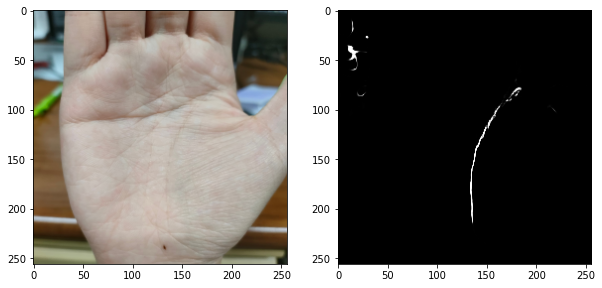

In [ ]:
for _, orig in images.items():
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
  ax[1].imshow(line[:,:,0], cmap = "gray")
  plt.show()

In [ ]:
print("生命線報告:")
print("-"*20)
for x,y in pred.items():
  if y > 0:
    m = meaning["生命線-"+x][0]
    print(x+" --> "+m)